In [11]:
from pyspark.sql import SparkSession
import pandas as pd
import librosa
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [12]:
spark = SparkSession.builder \
    .appName("DataPreprocessing") \
    .master("spark://localhost:7077") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [13]:
DATA_DIR = Path().resolve().parents[0]/'data'
TRAIN_DATA_PATH = str(DATA_DIR/'train-data/raw-train.jsonl')
TEST_DATA_PATH = str(DATA_DIR/'test-data/raw-test.jsonl')

In [14]:
train_data = spark.read\
    .option("header", True)\
    .option("inferSchema", True)\
    .json(TRAIN_DATA_PATH)

In [15]:
train_data.printSchema()

root
 |-- annotator_emo: string (nullable = true)
 |-- annotator_id: string (nullable = true)
 |-- audio_path: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- golden_emo: double (nullable = true)
 |-- hash_id: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- speaker_emo: string (nullable = true)
 |-- speaker_text: string (nullable = true)



* audio_path — путь к аудиофайлу;

* annotator_id — уникальный идентификатор разметчика, который оценивает эмоцию; 

* annotator_emo — эмоция, которую указал разметчик;

* golden_emo — эмоция контрольного задания;

* speaker_text — текст, который произнёс диктор;

* speaker_emo — эмоция, которую выражал диктор («заказанная» эмоция для разметчика-диктора из первой группы для семплов из Crowd, None для семплов из Podcasts);

* source_id — уникальный идентификатор диктора или подкаста.  

In [16]:
train_data.show(5)

+-------------+--------------------+--------------------+------------------+----------+--------------------+--------------------+-----------+--------------------+
|annotator_emo|        annotator_id|          audio_path|          duration|golden_emo|             hash_id|           source_id|speaker_emo|        speaker_text|
+-------------+--------------------+--------------------+------------------+----------+--------------------+--------------------+-----------+--------------------+
|        angry|858305a5450b7bd12...|wavs/475e76f77ac1...|2.4530000000000003|       NaN|475e76f77ac1ed7ca...|fa136da095807ea6c...|      angry|не надо не надо н...|
|      neutral|858305a5450b7bd12...|wavs/2f9438ef6839...|              4.64|       NaN|2f9438ef68395c70a...|3d436884cbbe25373...|    neutral|   фозил кори mp три|
|      neutral|858305a5450b7bd12...|wavs/9937036a9c0d...|           4.34175|       2.0|9937036a9c0dba20e...|               "NaN"|      "NaN"|               "NaN"|
|      neutral|858305a

In [17]:
train_data.select('duration', 'annotator_emo', 'audio_path').show(5)

+------------------+-------------+--------------------+
|          duration|annotator_emo|          audio_path|
+------------------+-------------+--------------------+
|2.4530000000000003|        angry|wavs/475e76f77ac1...|
|              4.64|      neutral|wavs/2f9438ef6839...|
|           4.34175|      neutral|wavs/9937036a9c0d...|
|         3.9005625|      neutral|wavs/fb0ae78586a2...|
|              4.78|      neutral|wavs/196dcf9e1aaa...|
+------------------+-------------+--------------------+
only showing top 5 rows



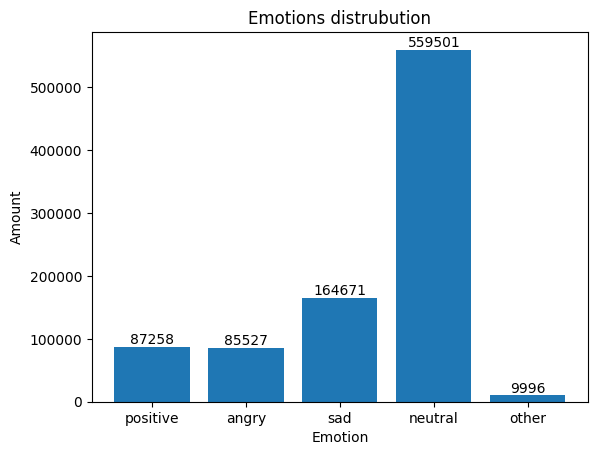

In [18]:
x_emo = np.arange(5)

emotions_amount = np.array(train_data.groupBy('annotator_emo').count().select('count').collect()).reshape(-1)
emo_label = np.array(train_data.select('annotator_emo').distinct().collect()).reshape(-1)

plt.bar(x_emo, emotions_amount)

for i in range(len(x_emo)):
    plt.text(x_emo[i], emotions_amount[i], str(emotions_amount[i]), ha='center', va='bottom')
    
plt.title('Emotions distrubution')
plt.xlabel('Emotion')
plt.ylabel('Amount')
plt.xticks(x_emo, emo_label)
plt.show()

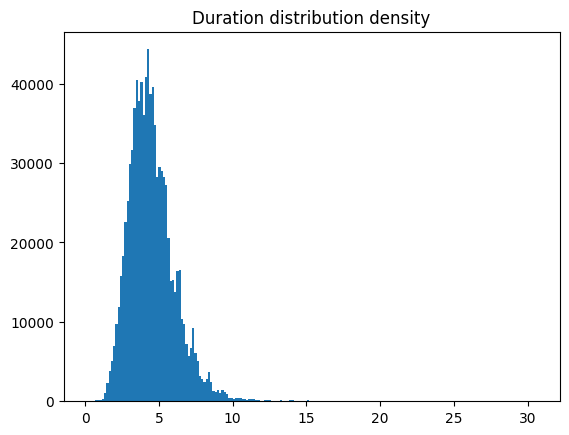

In [19]:
audio_duration = np.array(train_data.select('duration').collect()).reshape(-1)

plt.hist(audio_duration, bins=200)
plt.title('Duration distribution density')
plt.show()

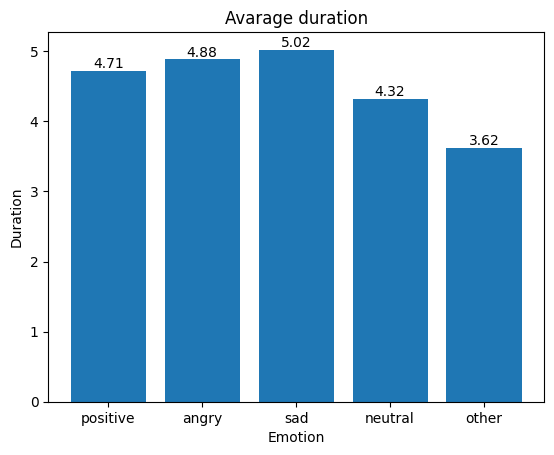

In [20]:
x_emo = np.arange(5)

avg_duration = np.array(train_data.groupBy('annotator_emo').avg('duration').select('avg(duration)').collect()).reshape(-1)
emo_label = np.array(train_data.select('annotator_emo').distinct().collect()).reshape(-1)

plt.bar(x_emo, avg_duration)

for i in range(len(x_emo)):
    plt.text(x_emo[i], avg_duration[i], str(avg_duration[i])[:4], ha='center', va='bottom')
    
plt.title('Avarage duration')
plt.xlabel('Emotion')
plt.ylabel('Duration')
plt.xticks(x_emo, emo_label)
plt.show()